In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import rnn
from mxnet.gluon import nn
npx.set_np()

#  09. Modern Recurrent Neural Networks
Although we have learned the basics of recurrent neural networks, they are not sufficient for a practitioner to solve today's sequence learning problems. For instance, given the numerical unstability during gradient calculation, gated recurrent neural networks are much more common in practice. We will begin by introducing two of such widely-used networks, namely `gated recurrent units` (`GRU`) and `long short term memory` (`LSTM`), with illustrations using the same language modeling problem as introduced in `Chapter 8`.

Furthermore, we will modify recurrent neural networks with a single undirectional hidden layer. We will describe deep architectures, and discuss the bidirectional design with both forward and backward recursion. They are frequently adopted in modern recurrent networks.

In fact, a large portion of sequence learning problems such as automatic speech recognition, text to speech, and machine translation, consider both inputs and outputs to be sequences of arbitrary length. Finally, we will take machine translation as an example, and introduce the encoder-decoder architecture based on recurrent neural networks and modern practices for such sequence to sequence learning problems.


## 9.5 Machine Translation and the Dataset
So far we see how to use recurrent neural networks for language models, in which we predict the next token given all previous tokens in an article. Now let us have a look at a different application, machine translation, whose predict output is no longer a single token, but a list of tokens.

`Machine translation` (`MT`) refers to the automatic translation of a segment of text from one language to another. Solving this problem with neural networks is often called `neural machine translation` (`NMT`). Compared to language models (`Section 8.3`), in which the corpus only contains a single language, machine translation dataset has at least two languages, the source language and the target language. In addition, each sentence in the source language is mapped to the according translation in the target language. Therefore, the data preprocessing for machine translation data is different to the one for language models. This section is dedicated to demonstrate how to pre-process such a dataset and then load into a set of minibatches.

### 9.5.1 Reading and Preprocessing the Dataset
We first download a dataset that contains a set of English sentences with the corresponding French translations. As can be seen that each line contains an English sentence with its French translation, which are separated by a `TAB`.

In [2]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[0:106])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !


We perform several preprocessing steps on the raw text data, including ignoring cases, replacing UTF-8 non-breaking space with space, and adding space between words and punctuation marks.

In [3]:
#@tab all
#@save
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[0:95])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who?	qui ?
wow !	ça alors !
fire !	au feu !


### 9.5.2 Tokenization
Different to using character tokens in `Section 8.3`, here a token is either a word or a punctuation mark. The following function tokenizes the text data to return source and target. Each one is a list of token list, with `source[i]` is the $i^\mathrm{th}$ sentence in the source language and `target[i]` is the $i^\mathrm{th}$ sentence in the target language. To make the latter training faster, we sample the first `num_examples` sentences pairs.

In [4]:
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['cours', '!']])

We visualize the histogram of the number of tokens per sentence in the following figure. As can be seen, a sentence in average contains 5 tokens, and most of the sentences have less than 10 tokens.

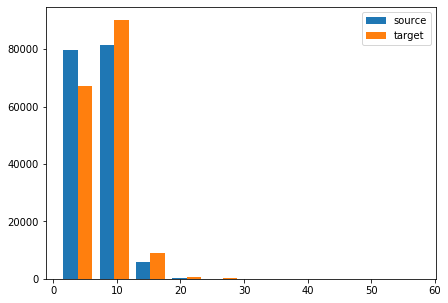

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]], label=['source', 'target'])
d2l.plt.legend(loc='upper right');

### 9.5.3 Vocabulary
Since the tokens in the source language could be different to the ones in the target language, we need to build a vocabulary for each of them. Since we are using words instead of characters as tokens, it makes the vocabulary size significantly large. Here we map every token that appears less than 3 times into the `<unk>` token `Section 8.2`. In addition, we need other special tokens such as padding and sentence beginnings.

In [6]:
src_vocab = d2l.Vocab(source, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

9140

### 9.5.4 Loading the Dataset
In language models, each example is a `num_steps` length sequence from the corpus, which may be a segment of a sentence, or span over multiple sentences. In machine translation, an example should contain a pair of source sentence and target sentence. These sentences might have different lengths, while we need same length examples to form a minibatch.

One way to solve this problem is that if a sentence is longer than `num_steps`, we trim its length, otherwise pad with a special `<pad>` token to meet the length. Therefore we could transform any sentence to a fixed length.

In [7]:
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]  # Trim
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

Now we can convert a list of sentences into an `(num_example, num_steps)` index array. We also record the length of each sentence without the padding tokens, called valid length, which might be used by some models. In addition, we add the special `<bos>` and `<eos>` tokens to the target sentences so that our model will know the signals for starting and ending predicting.

In [8]:
def build_array(lines, vocab, num_steps, is_source):
    lines = [vocab[l] for l in lines]
    if not is_source:
        lines = [[vocab['<bos>']] + l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(axis=1)
    return array, valid_len

Then we can construct minibatches based on these arrays.

### 9.5.5 Putting All Things Together
Finally, we define the function `load_data_nmt` to return the data iterator with the vocabularies for source language and target language.

In [9]:
def load_data_nmt(batch_size, num_steps, num_examples=1000):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array(source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, num_steps, False)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return src_vocab, tgt_vocab, data_iter

Let us read the first batch.

In [10]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, num_steps=8)
for X, X_vlen, Y, Y_vlen in train_iter:
    print('X:', X.astype('int32'))
    print('Valid lengths for X:', X_vlen)
    print('Y:', Y.astype('int32'))
    print('Valid lengths for Y:', Y_vlen)
    break

X: [[80  0  4  1  1  1  1  1]
 [32 36  4  1  1  1  1  1]]
Valid lengths for X: [3 3]
Y: [[ 2 15 14  0  4  3  1  1]
 [ 2 49  0  4  3  1  1  1]]
Valid lengths for Y: [6 5]


##### Summary
+ Machine translation (MT) refers to the automatic translation of a segment of text from one language to another.
+ We read, preprocess, and tokenize the datasets from both source language and target language.

##### Exercises
1. Find a machine translation dataset online and process it.


## 9.6 Encoder-Decoder Architecture
The `encoder-decoder` architecture is a neural network design pattern. As shown in `Fig. 9.6.1`, the architecture is partitioned into two parts, the `encoder` and the `decoder`. The `encoder`'s role is to encode the inputs into state, which often contains several tensors. Then the state is passed into the `decoder` to generate the outputs. In machine translation, the `encoder` transforms a source sentence, e.g., "Hello world.", into state, e.g., a vector, that captures its semantic information. The `decoder` then uses this state to generate the translated target sentence, e.g., "Bonjour le monde.".

<img src="images/09_12.png" style="width:400px;"/>

In this section, we will show an interface to implement this `encoder-decoder` architecture.

### 9.6.1 Encoder
The `encoder` is a normal neural network that takes inputs, e.g., a source sentence, to return outputs.

In [11]:
class Encoder(nn.Block):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

### 9.6.2 Decoder
The `decoder` has an additional method `init_state` to parse the outputs of the `encoder` with possible additional information, e.g., the valid lengths of inputs, to return the state it needs. In the `forward` method, the `decoder` takes both inputs, e.g., a target sentence and the state. It returns outputs, with potentially modified state if the `encoder` contains RNN layers.

In [12]:
class Decoder(nn.Block):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

### 9.6.3 Model
The `encoder-decoder` model contains both an `encoder` and a `decoder`. We implement its `forward` method for training. It takes both `encoder` inputs and `decoder` inputs, with optional additional arguments. During computation, it first computes `encoder` outputs to initialize the `decoder` state, and then returns the `decoder` outputs.

In [13]:
class EncoderDecoder(nn.Block):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

##### Summary
+ An `encoder-decoder` architecture is a neural network design pattern mainly in natural language processing.
+ An `encoder` is a network (FC, CNN, RNN, etc.) that takes the input, and outputs a feature map, a vector or a tensor.
+ A `decoder` is a network (usually the same network structure as `encoder`) that takes the feature vector from the `encoder`, and gives the best closest match to the actual input or intended output.

##### Exercises
1. Besides machine translation, can you think of another application scenarios where an `encoder-decoder` architecture can fit?
2. Can you design a deep `encoder-decoder` architecture?


## 9.7 Sequence to Sequence
The `sequence to sequence` (`seq2seq`) model is based on the `encoder-decoder` architecture to generate a sequence output for a sequence input, as demonstrated in `Fig. 9.7.1`. Both the `encoder` and the `decoder` use recurrent neural networks (`RNN`) to handle sequence inputs of variable length. The hidden state of the `encoder` is used directly to initialize the `decoder` hidden state to pass information from the `encoder` to the `decoder`.

<img src="images/09_13.png" style="width:500px;"/>

The layers in the `encoder` and the `decoder` are illustrated in `Fig. 9.7.2`.

<img src="images/09_14.png" style="width:350px;"/>

In this section we will explain and implement the `seq2seq` model to train on the machine translation dataset.

### 9.7.1 Encoder
Recall that the `encoder` of `seq2seq` can transform the inputs of variable length to a fixed-length context vector $\mathbf{c}$ by encoding the sequence information into $\mathbf{c}$. We usually use RNN layers within the `encoder`. Suppose that we have an input sequence $x_1, \ldots, x_T$, where $x_t$ is the $t^\mathrm{th}$ word. At timestep $t$, the RNN will have two vectors as the input: the feature vector $\mathbf{x}_t$ of $x_t$ and the hidden state of the last timestep $\mathbf{h}_{t-1}$. Let us denote the transformation of the RNN's hidden states by a function $f$:

$$\mathbf{h}_t = f (\mathbf{x}_t, \mathbf{h}_{t-1}).$$

Next, the `encoder` captures information of all the hidden states and encodes it into the context vector $\mathbf{c}$ with a function $q$:

$$\mathbf{c} = q (\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example, if we choose $q$ as $q (\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$, then the context vector will be the final hidden state $\mathbf{h}_T$.

So far what we describe above is a unidirectional RNN, where each timestep's hidden state depends only on the previous timesteps'. We can also use other forms of RNNs such as `GRU`, `LSTM`, and `bidirectional RNN` to encode the sequential input.

Now let us implement the `seq2seq`'s `encoder`. Here we use the word embedding layer to obtain the feature vector according to the word index of the input language. Those feature vectors will be fed to a multi-layer `LSTM`. The input for the encoder is a batch of sequences, which is 2-D tensor with shape `(batch size, sequence length)`. The encoder returns both the `LSTM` outputs, i.e., hidden states of all the timesteps, as well as the hidden state and the memory cell of the final timestep.

In [14]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        # RNN needs first axes to be timestep, i.e., seq_len
        X = X.swapaxes(0, 1)
        state = self.rnn.begin_state(batch_size=X.shape[1], ctx=X.ctx)
        out, state = self.rnn(X, state)
        # out shape: (seq_len, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens),
        # where "state" contains the hidden state and the memory cell
        return out, state

Next, we will create a minibatch sequence input with a batch size of 4 and 7 timesteps. We assume the number of hidden layers of the `LSTM` unit is 2 and the number of hidden units is 16. The output shape returned by the encoder after performing forward calculation on the input is `(number of timesteps, batch size, number of hidden units)`. The shape of the multi-layer hidden state of the gated recurrent unit in the final timestep is `(number of hidden layers, batch size, number of hidden units)`. For the gated recurrent unit, the state list contains only one element, which is the hidden state. If long short-term memory is used, the state list will also contain another element, which is the memory cell.

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.initialize()
X = np.zeros((4, 7))
output, state = encoder(X)
output.shape

(7, 4, 16)

Since an `LSTM` is used, the state list will contain both the hidden state and the memory cell with same shape `(number of hidden layers, batch size, number of hidden units)`. However, if a GRU is used, the state list will contain only one element---the hidden state in the final timestep with shape `(number of hidden layers, batch size, number of hidden units)`.

In [16]:
len(state), state[0].shape, state[1].shape

(2, (2, 4, 16), (2, 4, 16))

### 9.7.2 Decoder
As we just introduced, the context vector $\mathbf{c}$ encodes the information from the whole input sequence $x_1, \ldots, x_T$. Suppose that the given outputs in the training set are $y_1, \ldots, y_{T'}$. At each timestep $t'$, the conditional probability of output $y_{t'}$ will depend on the previous output sequence $y_1, \ldots, y_{t'-1}$ and the context vector $\mathbf{c}$, i.e.,

$$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}).$$

Hence, we can use another RNN as the `decoder`. At timestep $t'$, the `decoder` will update its hidden state $\mathbf{s}_{t'}$ using three inputs: 
+ the feature vector $\mathbf{y}_{t'-1}$ of $y_{t'-1}$
+ the context vector $\mathbf{c}$
+ the hidden state of the last timestep $\mathbf{s}_{t'-1}$

Let us denote the transformation of the RNN's hidden states within the `decoder` by a function $g$:

$$\mathbf{s}_{t'} = g(\mathbf{y}_{t'-1}, \mathbf{c}, \mathbf{s}_{t'-1}).$$

When implementing the `decoder`, we directly use the hidden state of the `encoder` in the final timestep as the initial hidden state of the decoder. This requires that the `encoder` and `decoder` RNNs have the same numbers of layers and hidden units. The `LSTM` forward calculation of the `decoder` is similar to that of the `encoder`. The only difference is that we add a dense layer after the `LSTM` layers, where the hidden size is the vocabulary size. The dense layer will predict the confidence score for each word.

In [17]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).swapaxes(0, 1)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).swapaxes(0, 1)
        return out, state

We create a `decoder` with the same hyper-parameters as the `encoder`. As we can see, the output shape is changed to `(batch size, the sequence length, vocabulary size)`.

In [18]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.initialize()
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

((4, 7, 10), 2, (2, 4, 16), (2, 4, 16))

### 9.7.3 The Loss Function
For each timestep, the `decoder` outputs a vocabulary-size confidence score vector to predict words. Similar to language modeling, we can apply softmax to obtain the probabilities and then use cross-entropy loss to calculate the loss. Note that we padded the target sentences to make them have the same length, but we do not need to compute the loss on the padding symbols.

To implement the loss function that filters out some entries, we will use an operator called `SequenceMask`. It can specify to mask the first dimension `(axis=0)` or the second one `(axis=1)`. If the second one is chosen, given a valid length vector `len` and 2-dim input $X$, this operator sets `X[i, len[i]:] = 0` for all $i$'s.

In [19]:
X = np.array([[1, 2, 3], [4, 5, 6]])
npx.sequence_mask(X, np.array([1, 2]), True, axis=1)

array([[1., 0., 0.],
       [4., 5., 0.]])

Apply to $n$-dim tensor $X$, it sets `X[i, len[i]:, :, ..., :] = 0`. In addition, we can specify the filling value such as $-1$ as shown below.

In [20]:
X = np.ones((2, 3, 4))
npx.sequence_mask(X, np.array([1, 2]), True, value=-1, axis=1)

array([[[ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.]]])

Now we can implement the masked version of the softmax cross-entropy loss. Note that each `Gluon` loss function allows to specify per-example weights, in default they are 1s. Then we can just use a zero weight for each example we would like to remove. So our customized loss function accepts an additional `valid_len` argument to ignore some failing elements in each sequence.

In [21]:
class MaskedSoftmaxCELoss(gluon.loss.SoftmaxCELoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_len shape: (batch_size, )
    def forward(self, pred, label, valid_len):
        # weights shape: (batch_size, seq_len, 1)
        weights = np.expand_dims(np.ones_like(label), axis=-1)
        weights = npx.sequence_mask(weights, valid_len, True, axis=1)
        return super(MaskedSoftmaxCELoss, self).forward(pred, label, weights)

For a sanity check, we create identical three sequences, keep 4 elements for the first sequence, 2 elements for the second sequence, and none for the last one. Then the first example loss should be 2 times larger than the second one, and the last loss should be 0.

In [22]:
loss = MaskedSoftmaxCELoss()
loss(np.ones((3, 4, 10)), np.ones((3, 4)), np.array([4, 2, 0]))

array([2.3025851, 1.1512926, 0.       ])

### 9.7.4 Training
During training, if the target sequence has length $n$, we feed the first $n-1$ tokens into the decoder as inputs, and the last $n-1$ tokens are used as ground truth label.

In [23]:
def train_s2s_ch9(model, data_iter, lr, num_epochs, ctx):
    model.initialize(init.Xavier(), force_reinit=True, ctx=ctx)
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr})
    loss = MaskedSoftmaxCELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.as_in_ctx(ctx) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            with autograd.record():
                Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
                l = loss(Y_hat, Y_label, Y_vlen)
            l.backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            trainer.step(num_tokens)
            metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print('loss %.3f, %d tokens/sec on %s ' % (metric[0]/metric[1], metric[1]/timer.stop(), ctx))

Next, we create a model instance and set hyper-parameters. Then, we can train the model.

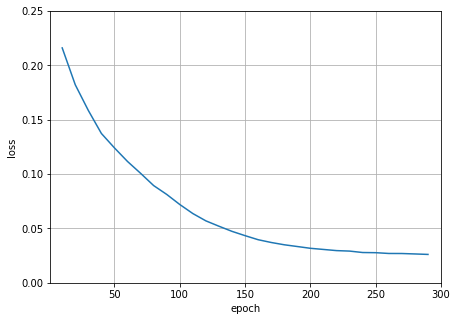

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 300, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

### 9.7.5 Predicting
Here we implement the simplest method, greedy search, to generate an output sequence. As illustrated in `Fig. 9.7.3`, during predicting, we feed the same `<bos>` token to the decoder as training at timestep 0. But the input token for a later timestep is the predicted token from the previous timestep.

<img src="images/09_15.png" style="width:400px;"/>

In [ ]:
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps, ctx):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_len = np.array([len(src_tokens)], ctx=ctx)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = np.array(src_tokens, ctx=ctx)
    # Add the batch_size dimension
    enc_outputs = model.encoder(np.expand_dims(enc_X, axis=0), enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = np.expand_dims(np.array([tgt_vocab['<bos>']], ctx=ctx), axis=0)
    predict_tokens = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next timestep input
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).astype('int32').item()
        if py == tgt_vocab['<eos>']:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

Try several examples:

In [ ]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + predict_s2s_ch9(model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

##### Summary
+ The sequence to sequence (seq2seq) model is based on the encoder-decoder architecture to generate a sequence output from a sequence input.
+ We use multiple LSTM layers for both the encoder and the decoder.

##### Exercises
1. Can you think of other use cases of seq2seq besides neural machine translation?
2. What if the input sequence in the example of this section is longer?
3. If we do not use the SequenceMask in the loss function, what may happen?


## 9.8 Beam Search
In `Section 9.7`, we discussed how to train an `encoder-decoder` with input and output sequences that are both of variable length. In this section, we are going to introduce how to use the `encoder-decoder` to predict sequences of variable length.

As in `Section 9.5`, when preparing to train the dataset, we normally attach a special symbol `<eos>` after each sentence to indicate the termination of the sequence. We will continue to use this mathematical symbol in the discussion below. For ease of discussion, we assume that the output of the `decoder` is a sequence of text. Let the size of output text dictionary $\mathcal{Y}$ (contains special symbol `<eos>`) be $\left|\mathcal{Y}\right|$, and the maximum length of the output sequence be $T'$. There are a total $\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$ types of possible output sequences. All the subsequences after the special symbol `<eos>` in these output sequences will be discarded. Besides, we still denote the context vector as $\mathbf{c}$, which encodes information of all the hidden states from the input.

### 9.8.1 Greedy Search
First, we will take a look at a simple solution: `greedy search`. For any timestep $t'$ of the output sequence, we are going to search for the word with the highest conditional probability from $|\mathcal{Y}|$ numbers of words, with

$$y_{t'} = \operatorname*{argmax}{y \in \mathcal{Y}} P(y \mid y_1, \ldots, y{t'-1}, \mathbf{c})$$

as the output. Once the `<eos>` symbol is detected, or the output sequence has reached its maximum length $T'$, the output is completed.

As we mentioned in our discussion of the decoder, the conditional probability of generating an output sequence based on the input sequence is $\prod_{t'=1}^{T'} P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$. We will take the output sequence with the highest conditional probability as the optimal sequence. The main problem with greedy search is that there is no guarantee that the optimal sequence will be obtained.

Take a look at the example below. We assume that there are four words `A`, `B`, `C`, and `<eos>` in the output dictionary. The four numbers under each timestep in `Fig. 9.8.1` represent the conditional probabilities of generating `A`, `B`, `C`, and `<eos>` at that timestep, respectively. At each timestep, greedy search selects the word with the highest conditional probability. Therefore, the output sequence `A`, `B`, `C`, and `<eos>` will be generated in `Fig. 9.8.1`. The conditional probability of this output sequence is $0.5\times0.4\times0.4\times0.6 = 0.048$.

<img src="images/09_16.png" style="width:600px;"/>

Now, we will look at another example shown in `Fig. 9.8.2`. Unlike in `Fig. 9.8.1`, the following figure `Fig. 9.8.2` selects the word `C`, which has the second highest conditional probability at timestep 2. Since the output subsequences of timesteps 1 and 2, on which timestep 3 is based, are changed from `A` and `B` in `Fig. 9.8.1` to `A` and `C` in `Fig. 9.8.2`, the conditional probability of each word generated at timestep 3 has also changed in `Fig. 9.8.2`. We choose the word `B`, which has the highest conditional probability. Now, the output subsequences of timestep 4 based on the first three timesteps are `A`, `C`, and `B`, which are different from `A`, `B`, and `C` in `Fig. 9.8.1`. Therefore, the conditional probability of generating each word in timestep 4 in `Fig. 9.8.2` is also different from that in `Fig. 9.8.1`. We find that the conditional probability of the output sequence `A`, `C`, `B`, and `<eos>` at the current timestep is $0.5\times0.3 \times0.6\times0.6=0.054$, which is higher than the conditional probability of the output sequence obtained by greedy search. Therefore, the output sequence `A`, `B`, `C`, and `<eos>` obtained by the greedy search is not an optimal sequence.

<img src="images/09_17.png" style="width:600px;"/>

### 9.8.2 Exhaustive Search
If the goal is to obtain the optimal sequence, we may consider using exhaustive search: an exhaustive examination of all possible output sequences, which outputs the sequence with the highest conditional probability.

Although we can use an exhaustive search to obtain the optimal sequence, its computational overhead $\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$ is likely to be excessively high. For example, when $|\mathcal{Y}|=10000$ and $T'=10$, we will need to evaluate $10000^{10} = 10^{40}$ sequences. This is next to impossible to complete. The computational overhead of greedy search is $\mathcal{O}(\left|\mathcal{Y}\right|T')$, which is usually significantly less than the computational overhead of an exhaustive search. For example, when $|\mathcal{Y}|=10000$ and $T'=10$, we only need to evaluate $10000\times10=1\times10^5$ sequences.

### 9.8.3 Beam Search
`Beam search` is an improved algorithm based on greedy search. It has a hyper-parameter named `beam size`, $k$. At timestep 1, we select $k$ words with the highest conditional probability to be the first word of the $k$ candidate output sequences. For each subsequent timestep, we are going to select the $k$ output sequences with the highest conditional probability from the total of $k\left|\mathcal{Y}\right|$ possible output sequences based on the $k$ candidate output sequences from the previous timestep. These will be the candidate output sequences for that timestep. Finally, we will filter out the sequences containing the special symbol `<eos>` from the candidate output sequences of each timestep and discard all the subsequences after it to obtain a set of final candidate output sequences.

<img src="images/09_18.png" style="width:600px;"/>
    
`Fig. 9.8.3` demonstrates the process of beam search with an example. Suppose that the vocabulary of the output sequence contains only five elements: $\mathcal{Y} = {A, B, C, D, E}$ where one of them is a special symbol `<eos>`. Set beam size to 2, the maximum length of the output sequence to 3. At timestep 1 of the output sequence, suppose the words with the highest conditional probability $P(y_1 \mid \mathbf{c})$ are $A$ and $C$. At timestep 2, for all $y_2 \in \mathcal{Y},$ we compute

$$P(A, y_2 \mid \mathbf{c}) = P(A \mid \mathbf{c})P(y_2 \mid A, \mathbf{c})$$

and

$$P(C, y_2 \mid \mathbf{c}) = P(C \mid \mathbf{c})P(y_2 \mid C, \mathbf{c}),$$

and pick the largest two among these 10 values, say

$$P(A, B \mid \mathbf{c}) \text{ and } P(C, E \mid \mathbf{c}).$$

Then at timestep 3, for all $y_3 \in \mathcal{Y}$, we compute

$$P(A, B, y_3 \mid \mathbf{c}) = P(A, B \mid \mathbf{c})P(y_3 \mid A, B, \mathbf{c})$$

and

$$P(C, E, y_3 \mid \mathbf{c}) = P(C, E \mid \mathbf{c})P(y_3 \mid C, E, \mathbf{c}),$$

and pick the largest two among these 10 values, say

$$P(A, B, D \mid \mathbf{c}) \text{ and } P(C, E, D \mid \mathbf{c}).$$

As a result, we obtain 6 candidates output sequences:
1. $A$
2. $C$
3. $A$, $B$
4. $C$, $E$
5. $A$, $B$, $D$
6. $C$, $E$, $D$

In the end, we will get the set of final candidate output sequences based on these 6 sequences.

In the set of final candidate output sequences, we will take the sequence with the highest score as the output sequence from those below:

$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}),$$

Here, $L$ is the length of the final candidate sequence and the selection for $\alpha$ is generally 0.75. The $L^\alpha$ on the denominator is a penalty on the logarithmic addition scores for the longer sequences above. The computational overhead $\mathcal{O}(k\left|\mathcal{Y}\right|T')$ of the beam search can be obtained through analysis. The result is between the computational overhead of greedy search and exhaustive search. In addition, greedy search can be treated as a beam search with a beam size of 1. Beam search strikes a balance between computational overhead and search quality using a flexible beam size of $k$.

##### Summary
+ Methods for predicting variable-length sequences include greedy search, exhaustive search, and beam search.
+ Beam search strikes a balance between computational overhead and search quality using a flexible beam size.

##### Exercises
1. Can we treat an exhaustive search as a beam search with a special beam size? Why?
2. We used language models to generate sentences in :numref:sec_rnn_scratch. Which kind of search does this output use? Can you improve it?